## Import des modules

In [315]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout

from keras import backend

#Ski-learn
from sklearn.model_selection import StratifiedKFold, GroupKFold

# Importation des données

In [316]:
train_data = pd.read_json("train.json", lines = True).drop('index' , axis = 1)
test_data = pd.read_json("test.json", lines = True).drop('index' , axis = 1)
sample_data = pd.read_csv("sample_submission.csv")

### Vérification des données

In [317]:
train_data.head()

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [318]:
test_data.head()

,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91


In [319]:
sample_data.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


## Data encoding

II)a) Filtrage des données 

In [320]:
train_data = train_data[train_data["SN_filter"] == 1]

In [321]:
train_data.head()

,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
5,id_00ab2d761,GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCA...,.....(.(((((.(((((((((...........)))))))..(((....,EEEEESISSSSSISSSSSSSSSHHHHHHHHHHHSSSSSSSMMSSSH...,4.136,1,107,68,"[0.1942, 0.2041, 0.1626, 0.1213, 0.10590000000...","[0.2726, 0.2984, 0.21660000000000001, 0.1637, ...","[0.3393, 0.2728, 0.2005, 0.1703, 0.1495, 0.134...","[0.165, 0.20520000000000002, 0.179, 0.1333, 0....","[0.2864, 0.24710000000000001, 0.2222, 0.1903, ...","[0.7642, 1.6641, 1.0622, 0.5008, 0.4107, 0.133...","[0.9559000000000001, 1.9442, 1.0114, 0.5105000...","[1.9554, 2.1298, 1.0403, 0.609, 0.5486, 0.386,...","[0.22460000000000002, 1.7281, 1.381, 0.6623, 0...","[0.5882000000000001, 1.1786, 0.9704, 0.6035, 0..."
6,id_00abef1d7,GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGG...,.........((((((((......((((((((((((....)))))))...,EEEEEEEEESSSSSSSSIIIIIISSSSSSSSSSSSHHHHSSSSSSS...,2.485,1,107,68,"[0.422, 0.5478000000000001, 0.4749000000000000...","[0.4801, 0.7943, 0.42160000000000003, 0.397300...","[0.9822000000000001, 1.272, 0.6940000000000001...","[0.5827, 0.7555000000000001, 0.5949, 0.4511, 0...","[0.9306000000000001, 1.0496, 0.5844, 0.7796000...","[0.895, 2.3377, 2.2305, 2.003, 1.9006, 1.0373,...","[0.46040000000000003, 3.6695, 0.78550000000000...","[2.7711, 7.365, 1.6924000000000001, 1.43840000...","[1.073, 2.8604000000000003, 1.9936, 1.0273, 1....","[2.0964, 3.3688000000000002, 0.6399, 2.1053, 1..."
7,id_00b436dec,GGAAAUCAUCGAGGACGGGUCCGUUCAGCACGCGAAAGCGUCGUGA...,.....(((((((((((..(((((((((..((((....))))..)))...,EEEEESSSSSSSSSSSIISSSSSSSSSIISSSSHHHHSSSSIISSS...,1.727,1,107,68,"[0.4843, 0.5233, 0.4554, 0.43520000000000003, ...","[0.8719, 1.0307, 0.6649, 0.34500000000000003, ...","[0.7045, 0.7775000000000001, 0.5662, 0.4561, 0...","[0.384, 0.723, 0.4766, 0.30260000000000004, 0....","[0.7429, 0.9137000000000001, 0.480400000000000...","[1.1576, 1.5137, 1.3382, 1.5622, 1.2121, 0.295...","[1.6912, 5.2652, 2.3901, 0.45890000000000003, ...","[1.8641, 2.3767, 1.149, 1.0132, 0.9876, 0.0, 0...","[0.49060000000000004, 4.6339, 1.95860000000000...","[1.2852000000000001, 2.5460000000000003, 0.234..."


### Création de x_train et y_train

In [322]:
x_train = train_data[["sequence", "structure", "predicted_loop_type"]]
y_train = train_data[["reactivity", "deg_Mg_pH10", "deg_pH10", "deg_Mg_50C", "deg_50C"]]

In [323]:
x_train.head()

,sequence,structure,predicted_loop_type
0,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...
2,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...
5,GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCA...,.....(.(((((.(((((((((...........)))))))..(((....,EEEEESISSSSSISSSSSSSSSHHHHHHHHHHHSSSSSSSMMSSSH...
6,GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGG...,.........((((((((......((((((((((((....)))))))...,EEEEEEEEESSSSSSSSIIIIIISSSSSSSSSSSSHHHHSSSSSSS...
7,GGAAAUCAUCGAGGACGGGUCCGUUCAGCACGCGAAAGCGUCGUGA...,.....(((((((((((..(((((((((..((((....))))..)))...,EEEEESSSSSSSSSSSIISSSSSSSSSIISSSSHHHHSSSSIISSS...


In [324]:
y_train.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,"[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
2,"[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
5,"[0.7642, 1.6641, 1.0622, 0.5008, 0.4107, 0.133...","[0.9559000000000001, 1.9442, 1.0114, 0.5105000...","[1.9554, 2.1298, 1.0403, 0.609, 0.5486, 0.386,...","[0.22460000000000002, 1.7281, 1.381, 0.6623, 0...","[0.5882000000000001, 1.1786, 0.9704, 0.6035, 0..."
6,"[0.895, 2.3377, 2.2305, 2.003, 1.9006, 1.0373,...","[0.46040000000000003, 3.6695, 0.78550000000000...","[2.7711, 7.365, 1.6924000000000001, 1.43840000...","[1.073, 2.8604000000000003, 1.9936, 1.0273, 1....","[2.0964, 3.3688000000000002, 0.6399, 2.1053, 1..."
7,"[1.1576, 1.5137, 1.3382, 1.5622, 1.2121, 0.295...","[1.6912, 5.2652, 2.3901, 0.45890000000000003, ...","[1.8641, 2.3767, 1.149, 1.0132, 0.9876, 0.0, 0...","[0.49060000000000004, 4.6339, 1.95860000000000...","[1.2852000000000001, 2.5460000000000003, 0.234..."


### One-hot encoding - x_train

#### One-hot encoding ARN

##### Création du dictionnaire ARN

In [325]:
arn_dico = {x:i for i, x in enumerate("ACGU")}

In [326]:
arn_dico

{'A': 0, 'C': 1, 'G': 2, 'U': 3}

##### Création du tableau de comptage

In [327]:
x_train_seq = x_train["sequence"].apply(lambda seq: [arn_dico[x] for x in seq])

In [328]:
np.shape(x_train_seq)

(1589,)

##### Mise en place dans un array ordonnée avec les 4 colonnes correspondant aux acides aminés

In [329]:
x_train_seq = np.array(x_train_seq.values.tolist())

In [330]:
print(x_train_seq)
np.shape(x_train_seq)

[[2 2 0 ... 0 0 1]
 [2 2 0 ... 0 0 1]
 [2 2 0 ... 0 0 1]
 ...
 [2 2 0 ... 0 0 1]
 [2 2 0 ... 0 0 1]
 [2 2 0 ... 0 0 1]]


(1589, 107)

Ordre des colonnes : A C G U

In [331]:
x_train_seq_cat = to_categorical(x_train_seq, 4)

In [332]:
print(x_train_seq_cat)
np.shape(x_train_seq_cat)

[[[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]

 ...

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]

 [[0. 0. 1. 0.]
  [0. 0. 1. 0.]
  [1. 0. 0. 0.]
  ...
  [1. 0. 0. 0.]
  [1. 0. 0. 0.]
  [0. 1. 0. 0.]]]


(1589, 107, 4)

#### One-hot encoding Structure

Création du dictionnaire Structure

In [333]:
structure_dico = {x:i for i, x in enumerate(".()")}
x_train_struct = x_train["structure"].apply(lambda seq: [structure_dico[x] for x in seq])
x_train_struct = np.array(x_train_struct.values.tolist())
x_train_struct_cat = to_categorical(x_train_struct, 3)

In [334]:
structure_dico

{'(': 1, ')': 2, '.': 0}

Ordre des colonnes : . ( )

In [335]:
print(x_train_struct_cat)
np.shape(x_train_struct_cat)

[[[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 ...

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]]


(1589, 107, 3)

#### One-hot encoding loop

Création du dictionnaire et mise en place du tableau loop

In [336]:
dico_loop = {x:i for i, x in enumerate("BEHIMSX")}
x_train_loop = x_train["predicted_loop_type"].apply(lambda seq: [dico_loop[x] for x in seq])
x_train_loop = np.array(x_train_loop.values.tolist())
x_train_loop_cat = to_categorical(x_train_loop, 7)

In [337]:
dico_loop

{'B': 0, 'E': 1, 'H': 2, 'I': 3, 'M': 4, 'S': 5, 'X': 6}

Ordre des colonnes : B E H I M S X

In [338]:
print(x_train_loop_cat)
np.shape(x_train_loop_cat)

[[[0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 ...

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]

 [[0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]]]


(1589, 107, 7)

### Concaténation des 3 tableaux dans x_train

In [339]:
print(x_train)
np.shape(x_train)

                                               sequence  ...                                predicted_loop_type
0     GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...  ...  EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...
2     GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...  ...  EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...
5     GGAAAGCGCCGCGGCGGUAGCGGCAGCGAGGAGCGCUACCAAGGCA...  ...  EEEEESISSSSSISSSSSSSSSHHHHHHHHHHHSSSSSSSMMSSSH...
6     GGAAAACAAUUGCAUCGUUAGUACGACUCCACAGCGUAAGCUGUGG...  ...  EEEEEEEEESSSSSSSSIIIIIISSSSSSSSSSSSHHHHSSSSSSS...
7     GGAAAUCAUCGAGGACGGGUCCGUUCAGCACGCGAAAGCGUCGUGA...  ...  EEEEESSSSSSSSSSSIISSSSSSSSSIISSSSHHHHSSSSIISSS...
...                                                 ...  ...                                                ...
2392  GGAAACUCCACAUCUCUACGCCACGAAAGUGGGUAGGAUGGGAGAG...  ...  EEEEESSSSBSSSSBSSSSBSSSSHHHHSSSSSSSSSSSSSSSSMS...
2393  GGAAAAGAUCGAUAGGUACGUGGGUUCAUGUAGGAAACUAGCUGGC...  ...  EEEEEESSSSIIIISSSSSSSSSSSBSSIISSSHHHHSSSII

(1589, 3)

In [340]:
x_train = np.concatenate((x_train_seq_cat, x_train_struct_cat, x_train_loop_cat), axis=2)

### Selectoin des 68 premières bases

In [341]:
x_train = x_train[:,:68,:]

In [342]:
np.shape(x_train)

(1589, 68, 14)

### Creation de y_train

In [343]:
y_train_reactivity =  np.array(y_train["reactivity"].values.tolist())

In [344]:
print(y_train_reactivity)
np.shape(y_train_reactivity)

[[ 0.3297  1.5693  1.1227 ...  0.2937  0.2362  0.5731]
 [ 0.4482  1.4822  1.1819 ...  0.6449  0.04    0.5446]
 [ 0.7642  1.6641  1.0622 ...  0.1107  0.2261  0.3238]
 ...
 [ 0.6957  1.251   1.3236 ... -0.0043  0.0521  0.0874]
 [ 0.2891  0.4496  0.7165 ...  0.8738  0.2816  0.554 ]
 [ 1.0102  1.7928  1.9228 ...  0.0381 -0.0066  0.0706]]


(1589, 68)

In [345]:
y_train_deg_Mg_pH10 =  np.array(y_train["deg_Mg_pH10"].values.tolist())
y_train_deg_Mg_50C =  np.array(y_train["deg_Mg_50C"].values.tolist())
y_train_deg_pH10 =  np.array(y_train["deg_pH10"].values.tolist())
y_train_deg_50C =  np.array(y_train["deg_50C"].values.tolist())

### Concaténation de y_train le long d'un nouvelle axe

In [346]:
y_train =  np.stack([y_train_reactivity, y_train_deg_Mg_pH10, y_train_deg_Mg_50C, y_train_deg_pH10, y_train_deg_50C], axis = 2)

In [347]:
print(y_train)
np.shape(y_train)

[[[ 3.2970e-01  7.5560e-01  3.5810e-01  2.3375e+00  6.3820e-01]
  [ 1.5693e+00  2.9830e+00  2.9683e+00  3.5060e+00  3.4773e+00]
  [ 1.1227e+00  2.5260e-01  2.5890e-01  3.0080e-01  9.9880e-01]
  ...
  [ 2.9370e-01  3.3360e-01  4.8120e-01  5.1420e-01  3.2870e-01]
  [ 2.3620e-01  6.4910e-01  7.0260e-01  7.6810e-01  5.3010e-01]
  [ 5.7310e-01  6.8980e-01  4.2540e-01  1.1720e+00  8.4720e-01]]

 [[ 4.4820e-01  2.5040e-01  5.1630e-01  2.2430e+00  9.5010e-01]
  [ 1.4822e+00  1.4021e+00  1.6823e+00  2.9361e+00  1.7975e+00]
  [ 1.1819e+00  9.8040e-01  1.0426e+00  1.0553e+00  1.4991e+00]
  ...
  [ 6.4490e-01  1.6819e+00  1.4640e+00  1.0621e+00  7.7890e-01]
  [ 4.0000e-02  5.3670e-01  4.2010e-01  4.3910e-01  3.3480e-01]
  [ 5.4460e-01  1.2400e+00  8.5750e-01  1.0076e+00  5.8270e-01]]

 [[ 7.6420e-01  9.5590e-01  2.2460e-01  1.9554e+00  5.8820e-01]
  [ 1.6641e+00  1.9442e+00  1.7281e+00  2.1298e+00  1.1786e+00]
  [ 1.0622e+00  1.0114e+00  1.3810e+00  1.0403e+00  9.7040e-01]
  ...
  [ 1.1070e-01  6.

(1589, 68, 5)

### Modèles d'évaluation en "10-fold Cross-Validation"

Choisir les données que l'ont veut prédire

In [348]:
y_train =  np.stack([y_train_reactivity, y_train_deg_Mg_pH10, y_train_deg_Mg_50C, y_train_deg_pH10, y_train_deg_50C], axis = 2)
y_train.shape[2]

5

In [349]:
print(y_train.shape)

(1589, 68, 5)


### One-hot encoding des données Tests

In [350]:
X_test_107 = test_data.query("seq_length == 107")
X_test_130 = test_data.query("seq_length == 130")

In [351]:
X_test_107.sum

<bound method DataFrame.sum of                 id  ... seq_scored
0     id_00073f8be  ...         68
2     id_00131c573  ...         68
3     id_00181fd34  ...         68
18    id_00ca60e44  ...         68
23    id_00e99b69c  ...         68
...            ...  ...        ...
3609  id_fd96725a9  ...         68
3616  id_fe2102731  ...         68
3622  id_febefd9c1  ...         68
3623  id_ff2d18b94  ...         68
3627  id_ff5b068b6  ...         68

[629 rows x 6 columns]>

In [352]:
X_test_130.sum

<bound method DataFrame.sum of                 id  ... seq_scored
1     id_000ae4237  ...         91
4     id_0020473f7  ...         91
5     id_002852873  ...         91
6     id_0031191b7  ...         91
7     id_003ab2445  ...         91
...            ...  ...        ...
3629  id_ff691b7e5  ...         91
3630  id_ff9bf3581  ...         91
3631  id_ffc8f96a8  ...         91
3632  id_ffd7e8cc1  ...         91
3633  id_ffda94f24  ...         91

[3005 rows x 6 columns]>

## Données Publiques (107 bp) - Test

In [353]:
#arn_dico = {x:i for i, x in enumerate("ACGU")}
X_test_107_seq = X_test_107["sequence"].apply(lambda seq: [arn_dico[x] for x in seq])
X_test_107_seq = np.array(X_test_107_seq.tolist())
X_test_107_seq = to_categorical(X_test_107_seq, 4)

In [354]:
#structure_dico = {x:i for i, x in enumerate(".()")}
X_test_107_struct = X_test_107["structure"].apply(lambda seq: [structure_dico[x] for x in seq])
X_test_107_struct = np.array(X_test_107_struct.values.tolist())
X_test_107_struct = to_categorical(X_test_107_struct, 3)

In [355]:
#dico_loop = {x:i for i, x in enumerate("BEHIMSX")}
X_test_107_loop = X_test_107["predicted_loop_type"].apply(lambda seq: [dico_loop[x] for x in seq])
X_test_107_loop = np.array(X_test_107_loop.values.tolist())
X_test_107_loop = to_categorical(X_test_107_loop, 7)

In [356]:
X_test_107_all = np.concatenate((X_test_107_seq, X_test_107_struct, X_test_107_loop), axis=2)

In [357]:
X_test_107_all = X_test_107_all[:,:68,:]

In [358]:
np.shape(X_test_107_all)

(629, 68, 14)

## Données Privées (130 bp) - Test

In [359]:
#arn_dico = {x:i for i, x in enumerate("ACGU")}
X_test_130_seq = X_test_130["sequence"].apply(lambda seq: [arn_dico[x] for x in seq])
X_test_130_seq = np.array(X_test_130_seq.tolist())
X_test_130_seq = to_categorical(X_test_130_seq, 4)

In [360]:
#structure_dico = {x:i for i, x in enumerate(".()")}
X_test_130_struct = X_test_130["structure"].apply(lambda seq: [structure_dico[x] for x in seq])
X_test_130_struct = np.array(X_test_130_struct.values.tolist())
X_test_130_struct = to_categorical(X_test_130_struct, 3)

In [361]:
#dico_loop = {x:i for i, x in enumerate("BEHIMSX")}
X_test_130_loop = X_test_130["predicted_loop_type"].apply(lambda seq: [dico_loop[x] for x in seq])
X_test_130_loop = np.array(X_test_130_loop.values.tolist())
X_test_130_loop = to_categorical(X_test_130_loop, 7)

In [362]:
X_test_130_all = np.concatenate((X_test_130_seq, X_test_130_struct, X_test_130_loop), axis=2)

# Définition des paramètres métriques et des graphiques d'analyse

## Evaluation du modèle

Dans ce projet, il est spécifier d'utiliser une certaine méthode pour le calcul de l'évaluation de notre modèle, la 'mean columnwise root mean square error' ou MCRMSE, définie comme :
$
MCRMSE = \frac{1}{N_t}\sum\limits_{j=1}^{N_t}\sqrt{\frac{1}{N}\sum\limits_{i=1}^{n}(y_{ij}-\hat{y_{ij}})^2}
$

On définit donc une fonction pour calculer selon cette équation :

In [363]:
def rmse(real_y, prediction_y):
    mse = tf.keras.losses.mean_squared_error(real_y, prediction_y)
    return backend.sqrt(mse)

def MCRMSE(real_y, prediction_y, score_n=y_train.shape[2]):
    score = 0
    for i in range(score_n):
        score += rmse(real_y[:, :, i], prediction_y[:, :, i]) / score_n
    return score

Pour voir l'évolution du modèle, on utilisera donc cette fonction à la place de la loss

### Visualisation des paramètres

Pour visualiser l'évolution des paramètres, on affichera après chaque apprentissage du modèle deux graphiques, représentants l'évolution de la MCRMSE et de la précision du modèle après chaque époques. Pour que le code reste lisible, on définit une fonction qui fera cet affichage en une ligne :

In [364]:
def plot_loss(model_history, title_model):
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])
  plt.xlabel("epochs")
  plt.ylabel("MCRMSE (loss)")
  plt.title(f"{title_model} loss (MCRMSE)")
  plt.legend(['train', 'val'], loc='upper left')

def plot_acc(model_history, title_model):
  plt.plot(model_history.history['accuracy'])
  plt.plot(model_history.history['val_accuracy'])
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.title (f"{title_model} accuracy")
  plt.legend(['train', 'val'], loc='upper left')

La visualisation de la précision du modèle reste peu fiable car elle est basée sur les même données que l'apprentissage. Elle nous permettera donc d'évaluer provisoirement le modèle mais une deuxième évaluation devra être réalisée avec les données tests. 

# Création des modèles et première évaluation

## Modèle Dense simple

Dans un permier temps, nous allons tester un modèle simple, composer uniquement de couche de type Dense

In [365]:
# Création d'un modèle Dense en séquentiel
model_dense = Sequential()
model_dense.add(Dense(64, input_shape=(68, 14), activation='softmax'))
model_dense.add(Dense(32, activation="softmax"))
model_dense.add(Dense(16, activation="softmax"))
model_dense.add(Dense(5, activation = "linear"))

model_dense.compile(optimizer="adam", loss= MCRMSE, metrics=['accuracy'])

model_dense.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 68, 64)            960       
_________________________________________________________________
dense_25 (Dense)             (None, 68, 32)            2080      
_________________________________________________________________
dense_26 (Dense)             (None, 68, 16)            528       
_________________________________________________________________
dense_27 (Dense)             (None, 68, 5)             85        
Total params: 3,653
Trainable params: 3,653
Non-trainable params: 0
_________________________________________________________________


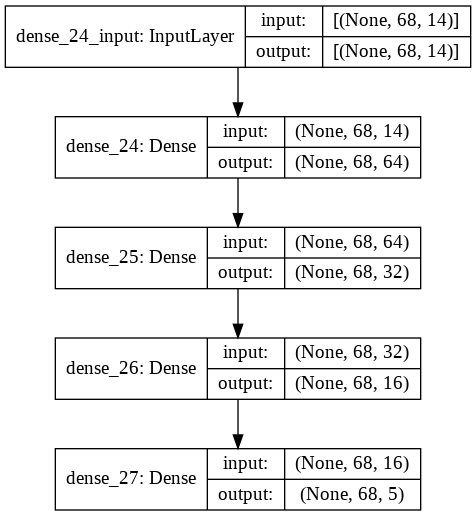

In [366]:
tf.keras.utils.plot_model(model_dense, "Dense_model.png", show_shapes=True)

In [367]:
history_dense = model_dense.fit(x_train, y_train, epochs= 100, batch_size= 200, validation_split= 0.2)

Epoch 1/100
7/7 [==============================] - 2s 81ms/step - loss: 0.5953 - accuracy: 0.2193 - val_loss: 0.5903 - val_accuracy: 0.2266
Epoch 2/100
7/7 [==============================] - 0s 32ms/step - loss: 0.5859 - accuracy: 0.2193 - val_loss: 0.5812 - val_accuracy: 0.2266
Epoch 3/100
7/7 [==============================] - 0s 41ms/step - loss: 0.5769 - accuracy: 0.2193 - val_loss: 0.5726 - val_accuracy: 0.2266
Epoch 4/100
7/7 [==============================] - 0s 33ms/step - loss: 0.5683 - accuracy: 0.2193 - val_loss: 0.5643 - val_accuracy: 0.2266
Epoch 5/100
7/7 [==============================] - 0s 32ms/step - loss: 0.5601 - accuracy: 0.2193 - val_loss: 0.5564 - val_accuracy: 0.2266
Epoch 6/100
7/7 [==============================] - 0s 32ms/step - loss: 0.5523 - accuracy: 0.2193 - val_loss: 0.5490 - val_accuracy: 0.2266
Epoch 7/100
7/7 [==============================] - 0s 33ms/step - loss: 0.5449 - accuracy: 0.2193 - val_loss: 0.5420 - val_accuracy: 0.2266
Epoch 8/100
7/7 [===

In [368]:
print(history_dense.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


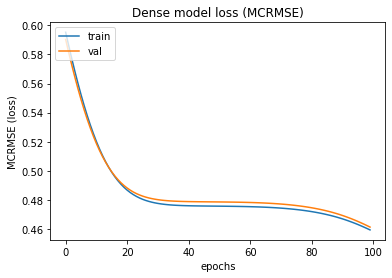

In [369]:
plot_loss(history_dense, "Dense model")

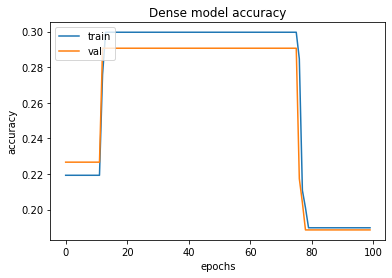

In [370]:
plot_acc(history_dense, "Dense model")

## Modèle de deep learning adaptés aux données séquentielles


### Définition d'une fonction de construction de modèles

La nature séquentielle des données que nous utilisons tend à choisir un modèle plus adapté à ce type. Dans les modèles adpaté, on trouve notamment les Recurent Neural Network (RNN), ainsi que plsuieurs varaint de ces modèles, comme les GRU, les LSTM ainsi que les BERT. Le module Keras fourni plusieurs fonction pour ces modèles, on testera donc certains de ces modèles pour en déterminer le plus efficace pour nos données.

Dans cet objectif de construire plusieurs modèles de type RNN, on implémente des fonctions de construction pour simplifier la lecture du code par la suite :

In [371]:
# définition des layers de type RNN simple
def simple_rnn_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.SimpleRNN(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))

# définition des layers de type GRU
def gru_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))

# définition des layers de type LSTM
def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))

# définition de la fonction pour construire les modèles 
def build_model(rnn = 'gru', convolve=False, conv_dim=256, 
                dropout=.2, hidden_dim=128, layers=3, pred_len=68):

    inputs = tf.keras.layers.Input(shape=(pred_len, 14)) # couche d'entrée, correspondant au 68 bases sélectionner et leur One-Hot encoding pour la base, la structure dans la séquence et la structure de la boucle
    hidden = inputs # passage de l'entrée pour les couches cachées (GRU ou LSTM)
    if convolve:
        hidden = tf.keras.layers.Conv1D(conv_dim, 5, padding='same', activation=tf.keras.activations.swish)(hidden)
    if rnn is 'simple_rnn':
      # construit un modèle avec un nombre de couche de type SimpleRNN défini dans l'appel
      for _ in range(layers):
        hidden = simple_rnn_layer(hidden_dim, dropout)(hidden)

    if rnn is 'gru':
        # construit un modèle avec un nombre de couche de type GRU défini dans l'appel 
        for _ in range(layers):
            hidden = gru_layer(hidden_dim, dropout)(hidden)   
    elif rnn is 'lstm':
        # construit un modèle avec un nombre de couche de type LSTM défini dans l'appel
        for _ in range(layers):
            hidden = lstm_layer(hidden_dim, dropout)(hidden)
    out = hidden
    # redimension du nombre de sorties pour la prédiction des 5 paramètres (reactivity, deg_Mg_pH10, deg_Mg_50C, deg_pH10, deg_50C)
    out = tf.keras.layers.Dense(5, activation='linear')(out)
    
    model = tf.keras.Model(inputs=inputs, outputs=out)
    adam = tf.optimizers.Adam() # définition de l'optimiseur
    model.compile(optimizer=adam, loss=MCRMSE, metrics = ['accuracy']) #compilation du modèle avec pour calcul de l'erreur la MCRMSE

    return model

## Modèle RNN simple

Dans un premier temps, on commence par tester un modèle simple de RNN fourni par Keras.

In [372]:
model_simple_rnn = build_model(rnn = 'simple_rnn', convolve=True)
model_simple_rnn.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 68, 14)]          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 68, 256)           18176     
_________________________________________________________________
bidirectional_50 (Bidirectio (None, 68, 256)           98560     
_________________________________________________________________
bidirectional_51 (Bidirectio (None, 68, 256)           98560     
_________________________________________________________________
bidirectional_52 (Bidirectio (None, 68, 256)           98560     
_________________________________________________________________
dense_28 (Dense)             (None, 68, 5)             1285      
Total params: 315,141
Trainable params: 315,141
Non-trainable params: 0
____________________________________________________

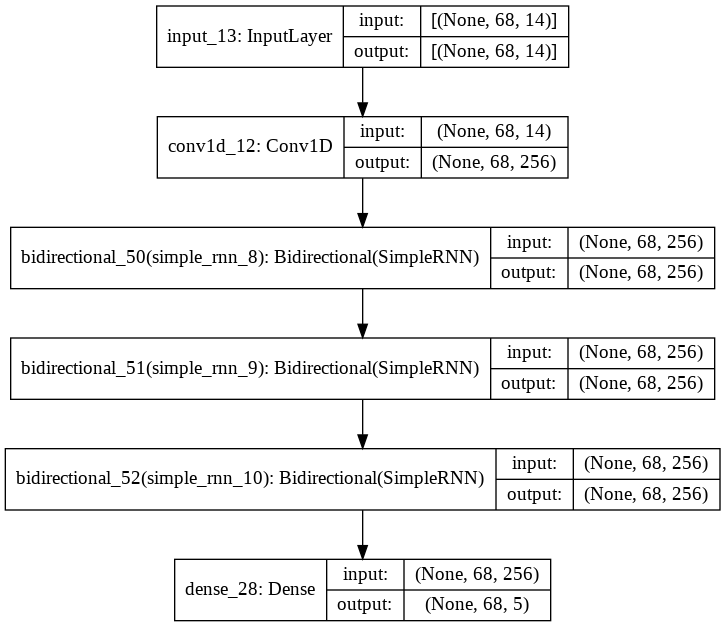

In [373]:
tf.keras.utils.plot_model(model_simple_rnn, "SimpleRNN_model.png", show_shapes=True)

In [286]:
history_simple_rnn = model_simple_rnn.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split= 0.2)

Epoch 1/50
10/10 [==============================] - 16s 1s/step - loss: 0.7579 - accuracy: 0.2176 - val_loss: 0.4680 - val_accuracy: 0.3409
Epoch 2/50
10/10 [==============================] - 9s 930ms/step - loss: 0.5119 - accuracy: 0.2399 - val_loss: 0.3770 - val_accuracy: 0.2208
Epoch 3/50
10/10 [==============================] - 9s 919ms/step - loss: 0.4258 - accuracy: 0.2606 - val_loss: 0.3532 - val_accuracy: 0.2081
Epoch 4/50
10/10 [==============================] - 9s 917ms/step - loss: 0.3826 - accuracy: 0.2638 - val_loss: 0.3368 - val_accuracy: 0.3565
Epoch 5/50
10/10 [==============================] - 9s 910ms/step - loss: 0.3566 - accuracy: 0.2844 - val_loss: 0.3262 - val_accuracy: 0.3397
Epoch 6/50
10/10 [==============================] - 9s 909ms/step - loss: 0.3413 - accuracy: 0.2927 - val_loss: 0.3233 - val_accuracy: 0.3571
Epoch 7/50
10/10 [==============================] - 9s 914ms/step - loss: 0.3315 - accuracy: 0.3105 - val_loss: 0.3158 - val_accuracy: 0.3572
Epoch 8/

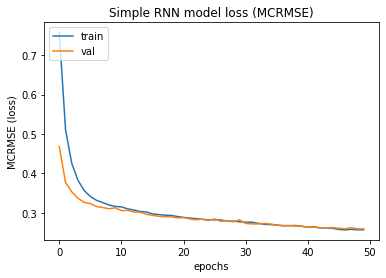

In [287]:
plot_loss(history_simple_rnn, "Simple RNN model")

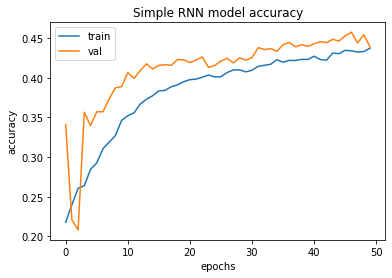

In [288]:
plot_acc(history_simple_rnn, "Simple RNN model")

Le RNN simple n'apprend pas de manière optimale car il n'est pas fiable pour les dépendances à long terme à cause de la disparition du gradient, dans cette optique les solutions possibles sont l'utilisation de RNN plus complexes comme LSTM et GRU.


## Modèle GRU

On construit dans un premiers temps un modèle GRU à trois couche et un couche Dense pour redimensioner les sorties sur les 5 paramètres à prédire :

In [289]:
model_gru = build_model(rnn = 'gru', convolve=True) # construction d'un modèle GRU à 3 couches
model_gru.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 68, 14)]          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 68, 256)           18176     
_________________________________________________________________
bidirectional_41 (Bidirectio (None, 68, 256)           296448    
_________________________________________________________________
bidirectional_42 (Bidirectio (None, 68, 256)           296448    
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 68, 256)           296448    
_________________________________________________________________
dense_21 (Dense)             (None, 68, 5)             1285      
Total params: 908,805
Trainable params: 908,805
Non-trainable params: 0
_____________________________________________________

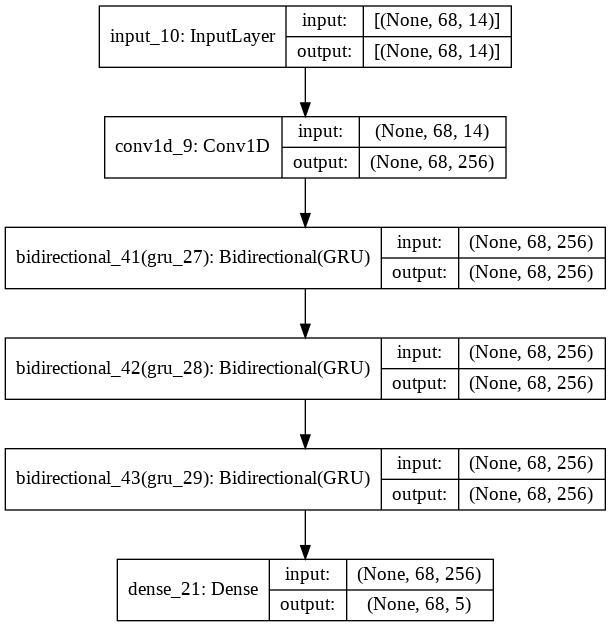

In [290]:
tf.keras.utils.plot_model(model_gru, "GRU_model.png", show_shapes=True)

Fit du modèle GRU précédemment construit sur les données d'entrainement du modèle. On désigne 50 époques avec des tailles de batchs de 64, la fin de chaque époque considère une validation de 20% des données d'entrainement, sur lesquels ont détermine notre erreur (ou loss) selon la MCRMSE, comme indiqué dans le sujet :

In [291]:
history_gru = model_gru.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2)

Epoch 1/50
10/10 [==============================] - 31s 2s/step - loss: 0.4850 - accuracy: 0.2862 - val_loss: 0.4206 - val_accuracy: 0.3400
Epoch 2/50
10/10 [==============================] - 19s 2s/step - loss: 0.4031 - accuracy: 0.3306 - val_loss: 0.3926 - val_accuracy: 0.2999
Epoch 3/50
10/10 [==============================] - 19s 2s/step - loss: 0.3814 - accuracy: 0.3346 - val_loss: 0.3715 - val_accuracy: 0.3366
Epoch 4/50
10/10 [==============================] - 19s 2s/step - loss: 0.3666 - accuracy: 0.3471 - val_loss: 0.3585 - val_accuracy: 0.3819
Epoch 5/50
10/10 [==============================] - 19s 2s/step - loss: 0.3536 - accuracy: 0.3661 - val_loss: 0.3479 - val_accuracy: 0.3851
Epoch 6/50
10/10 [==============================] - 19s 2s/step - loss: 0.3433 - accuracy: 0.3720 - val_loss: 0.3369 - val_accuracy: 0.3890
Epoch 7/50
10/10 [==============================] - 19s 2s/step - loss: 0.3341 - accuracy: 0.3772 - val_loss: 0.3323 - val_accuracy: 0.3972
Epoch 8/50
10/10 [==

On trace la valeur de la MCRMSE à chaque époques, en fonction de l'entrainement et de la validation du modèle :

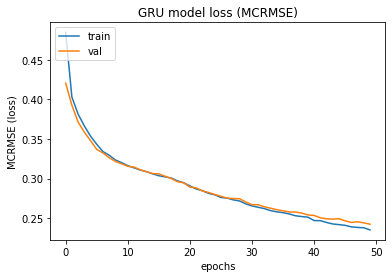

In [292]:
plot_loss(history_gru, "GRU model")

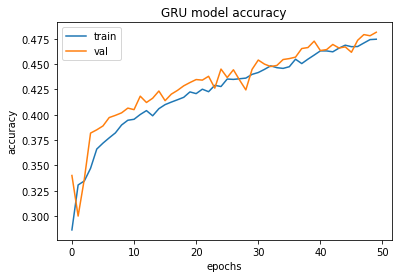

In [293]:
plot_acc(history_gru, "GRU model")

## Modèle LSTM



In [294]:
model_lstm = build_model(rnn = 'lstm', convolve=True)
model_lstm.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 68, 14)]          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 68, 256)           18176     
_________________________________________________________________
bidirectional_44 (Bidirectio (None, 68, 256)           394240    
_________________________________________________________________
bidirectional_45 (Bidirectio (None, 68, 256)           394240    
_________________________________________________________________
bidirectional_46 (Bidirectio (None, 68, 256)           394240    
_________________________________________________________________
dense_22 (Dense)             (None, 68, 5)             1285      
Total params: 1,202,181
Trainable params: 1,202,181
Non-trainable params: 0
________________________________________________

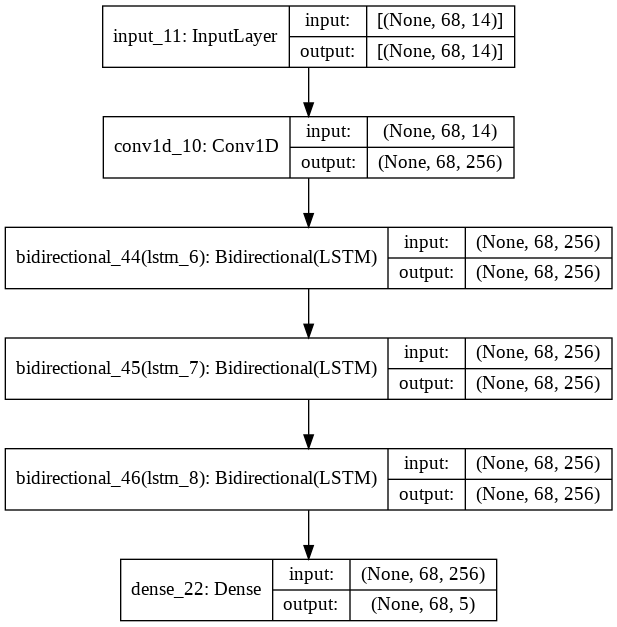

In [295]:
tf.keras.utils.plot_model(model_lstm, "LSTM_model.png", show_shapes=True)

In [296]:
history_lstm = model_lstm.fit(x_train, y_train, epochs = 50, batch_size = 128, validation_split=0.2)

Epoch 1/50
10/10 [==============================] - 37s 3s/step - loss: 0.5144 - accuracy: 0.2778 - val_loss: 0.4654 - val_accuracy: 0.3124
Epoch 2/50
10/10 [==============================] - 22s 2s/step - loss: 0.4365 - accuracy: 0.2968 - val_loss: 0.4172 - val_accuracy: 0.3035
Epoch 3/50
10/10 [==============================] - 22s 2s/step - loss: 0.3978 - accuracy: 0.3183 - val_loss: 0.3875 - val_accuracy: 0.3426
Epoch 4/50
10/10 [==============================] - 22s 2s/step - loss: 0.3819 - accuracy: 0.3271 - val_loss: 0.3757 - val_accuracy: 0.3412
Epoch 5/50
10/10 [==============================] - 23s 2s/step - loss: 0.3701 - accuracy: 0.3413 - val_loss: 0.3679 - val_accuracy: 0.3201
Epoch 6/50
10/10 [==============================] - 23s 2s/step - loss: 0.3620 - accuracy: 0.3449 - val_loss: 0.3623 - val_accuracy: 0.3384
Epoch 7/50
10/10 [==============================] - 22s 2s/step - loss: 0.3552 - accuracy: 0.3510 - val_loss: 0.3534 - val_accuracy: 0.3768
Epoch 8/50
10/10 [==

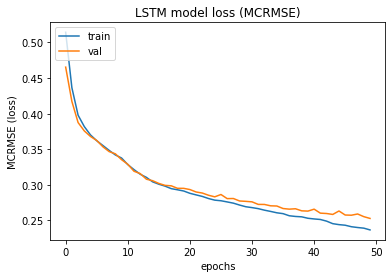

In [297]:
plot_loss(history_lstm, "LSTM model")

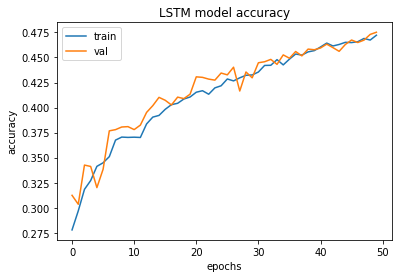

In [298]:
plot_acc(history_lstm, "LSTM model")

# Test et Création des modèles sur les données Test privées et Test publiques

## Creation de y_pred_107

In [299]:
X_test_107_all = X_test_107_all[:,:68,:]

In [300]:
y_pred_107

array([[[ 0.84136426,  0.67445123,  0.6275376 ,  2.0862355 ,
          0.75275475],
        [ 2.7958517 ,  3.7490776 ,  3.7865555 ,  5.0956016 ,
          3.1176686 ],
        [ 1.6990275 ,  0.6397338 ,  0.99030024,  0.7828387 ,
          0.7995934 ],
        ...,
        [ 0.27759942,  0.62680817,  0.5453924 ,  0.38983783,
          0.3273067 ],
        [ 0.21745667,  0.5879618 ,  0.569338  ,  0.5849478 ,
          0.5443819 ],
        [ 0.23058835,  0.6579917 ,  0.48121822,  0.8770796 ,
          0.5706666 ]],

       [[ 0.5583596 ,  0.5942317 ,  0.50350285,  2.447615  ,
          0.64122605],
        [ 1.3742884 ,  1.5143178 ,  1.6848607 ,  3.0442028 ,
          1.763679  ],
        [ 1.3236331 ,  0.8439295 ,  1.2202411 ,  1.2494352 ,
          1.0755744 ],
        ...,
        [ 0.3153082 ,  0.70079005,  0.8910148 ,  0.7853315 ,
          0.6630028 ],
        [ 0.4596242 ,  0.34825474,  0.46152687,  0.40662295,
          0.46794632],
        [ 0.32439038,  0.5896785 ,  0.43594566, 

In [301]:
np.shape(y_pred_107)

(629, 68, 5)

In [302]:
flag = 1
for line in signal_noise:
  if min(line) > -0.5:
    flag = flag * 1
  else:
    flage = flag * 0
if flag == 1:
  print("test réussi")
else:
  print("test échoué")

test réussi


In [303]:
import scipy

In [304]:
signal_noise = []
for line in y_pred_107:
  signal_noise.append(np.mean(line)/scipy.stats.sem(line))

In [305]:
flag = 1
for line in signal_noise:
  if min(line) < 1:
    flage = flag * 0
  else:
    flag = flag * 1

if flag == 1:
  print("test réussi")
else:
  print("test échoué")

test réussi


- Le test sur la valeur minimale pour les 5 conditions qui doit être supérieure à -0,5. est ok
- Le test sur le rapport signal/bruit moyen dans les 5 conditions qui doit être supérieur à 1,0. (Le signal / bruit est défini comme moyenne (valeur de mesure supérieure à 68 nts) / moyenne (erreur statistique de la valeur de mesure supérieure à 68 nts)) Est réussi !

On peut dire que le modèle semble plutot fiable, mais on ne peut pas être à 100%. (On pourrait eventuelklement effectuer des modeles plus complexe avec une meilleur loss pour tendre vers une plus grande fiabilité)

## Creation du y_pred_130

In [306]:
X_test_130_all = X_test_130_all[:,:91,:]

In [307]:
np.shape(X_test_130_all)

(3005, 91, 14)

In [308]:
model_gru_130 = build_model(rnn='gru', pred_len=91, convolve=True)

In [309]:
model_gru_130.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 91, 14)]          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 91, 256)           18176     
_________________________________________________________________
bidirectional_47 (Bidirectio (None, 91, 256)           296448    
_________________________________________________________________
bidirectional_48 (Bidirectio (None, 91, 256)           296448    
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 91, 256)           296448    
_________________________________________________________________
dense_23 (Dense)             (None, 91, 5)             1285      
Total params: 908,805
Trainable params: 908,805
Non-trainable params: 0
____________________________________________________

In [310]:
model_gru_130.set_weights(model_gru.get_weights())

In [311]:
y_pred_130 = model_gru_130.predict(X_test_130_all)

In [312]:
y_pred_130

array([[[ 0.63733137,  0.6735015 ,  0.514787  ,  1.7233236 ,
          0.60291433],
        [ 1.4372928 ,  2.2474134 ,  1.965734  ,  2.52692   ,
          1.4665165 ],
        [ 1.1993508 ,  0.79701346,  1.0118043 ,  1.0312355 ,
          1.0701588 ],
        ...,
        [ 0.30080602,  0.75961065,  0.7810803 ,  0.88402647,
          0.6715245 ],
        [ 0.44953716,  0.48605344,  0.5095356 ,  0.5858491 ,
          0.51290643],
        [ 0.2523579 ,  0.6521358 ,  0.4579745 ,  0.92561346,
          0.5310923 ]],

       [[ 0.63942   ,  0.7231948 ,  0.52325165,  1.5909585 ,
          0.56223166],
        [ 1.547584  ,  2.6937706 ,  2.2534351 ,  2.695279  ,
          1.55462   ],
        [ 1.1351844 ,  0.9017021 ,  1.0382956 ,  1.0772625 ,
          0.9595444 ],
        ...,
        [-0.01651619,  0.13972622,  0.06020609,  0.08761413,
          0.09673852],
        [ 0.06120928,  0.32891333,  0.1556775 ,  0.29801208,
          0.23295842],
        [ 0.22131829,  0.90770453,  0.43806678, 

On ne sait pas si ça passe le SN_Filer sur les données Privates, donc on ne peut pas checker. (On peut essayer de calculer le signal_noise pour voir la proportions des privates et voir combien passent, mais donne aucune indication réelle)

# Création de tableau des résultats (CSV)

In [313]:
#Télécharger les fichiers de données
from google.colab import files

In [314]:
ls_prediction = []
cols_prediction = ["reactivity", "deg_Mg_pH10", "deg_pH10", "deg_Mg_50C", "deg_50C"]
for df, prediction in [(X_test_107, y_pred_107), (X_test_130, y_pred_130)]:
    for i, uid in enumerate(df.id):
        unique_predicate = prediction[i]
        data_unique = pd.DataFrame(unique_predicate, columns=cols_prediction)
        data_unique['id_seqpos'] = [f'{uid}_{x}' for x in range(data_unique.shape[0])]
        ls_prediction.append(data_unique)
data_prediction = pd.concat(ls_prediction)
submission = sample_data[['id_seqpos']].merge(data_prediction, on=['id_seqpos'])
submission.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>